In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

### 1. 데이터 셋 준비하기
---

In [2]:
import urllib3
urllib3.disable_warnings()

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True
)

In [3]:
print(ds_info.features)
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})
tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


### input Normalization

In [4]:
def normalize_and_resize_img(image, label):
    return tf.cast(image, tf.float32) / 255, label

In [5]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
    normalize_and_resize_img,
    num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

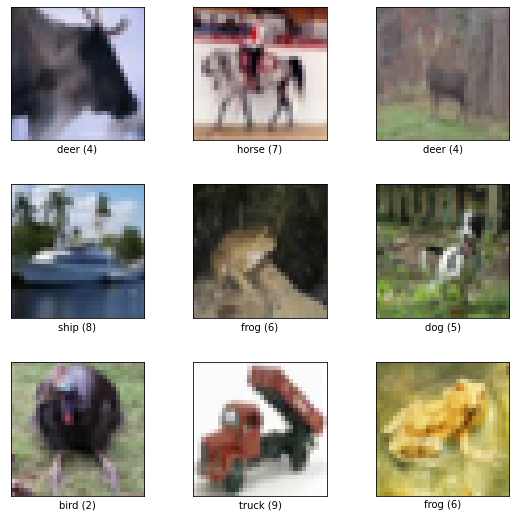

In [6]:
fig = tfds.show_examples(ds_train, ds_info)

### 2. 블록 구성하기
---

### Conv Block

In [15]:
def conv_block(layer, channel, kernel_size, name, padding='same', strides=1, activation='relu'):
    x = keras.layers.Conv2D(filters=channel,
                            kernel_size=kernel_size,
                            padding=padding,
                            strides=strides,
                            name=f'conv_{name}')(layer)
    x = keras.layers.BatchNormalization(name=f'batch_{name}')(x)
    if activation:
        x = keras.layers.Activation(activation, name=f'act_{name}')(x)
    
    return x               

###  Residual Block

In [14]:
def residual_block(input_layer, block_num=0, num_cnn=3, channel=64, is_50=True):
    x = input_layer
    
    if is_50:
        for i in range(num_cnn):
            if i==0:
                shortcut = conv_block(layer=x, 
                                      channel=channel*4, 
                                      kernel_size=(1,1),
                                      name=f'shortcut_{block_num}_{i}',
                                      strides=2,
                                      activation=None)
                x = conv_block(x, channel, (1,1), name=f'{block_num}_{i}1',  strides=2)
                x = conv_block(x, channel, (3,3), name=f'{block_num}_{i}2', )
                x = conv_block(x, channel*4, (1,1), name=f'{block_num}_{i}3', activation=None)
            
            else:
                shortcut = x
                x = conv_block(x, channel, (1,1), name=f'{block_num}_{i}1')
                x = conv_block(x, channel, (3,3), name=f'{block_num}_{i}2')
                x = conv_block(x, channel*4, (1,1), name=f'{block_num}_{i}3', activation=None)
        x = keras.layers.Add(name=f'shortcut_add_{block_num}_{i}')([x, shortcut])
        x = keras.layers.Activation('relu', name=f'shortcut_act_{block_num}_{i}')
            
    else:
        for i in range(num_cnn):
            if block_num > 0 and i==0:
                shortcut = conv_block(x, channel, (1,1), name=f'_shortcut_{block_num}_{i}', strides=2, activation=None)
                x = conv_block(x, channel, (3,3), name=f'{block_num}_{i}1', strides=2)
                x = conv_block(x, channel, (3,3), name=f'{block_num}_{i}2', activation=None)
            
            else:
                shortcut = x
                x = conv_block(x, channel, (3,3), name=f'{block_num}_{i}1')
                x = conv_block(x, channel, (3,3), name=f'{block_num}_{i}2', activation=None)
            
            x = keras.layers.Add(name=f'shortcut_add_{block_num}_{i}')([x, shortcut])
            x = keras.layers.Activation('relu', name=f'shortcut_act_{block_num}_{i}')(x)
    
    return x
                                        

### Plain Block

In [9]:
def plain_block(input_layer, block_num=0, num_cnn=3, channel=64, is_50=True):
    x = input_layer
    
    if is_50:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (1,1), name=f'{block_num}_{i}1', strides=2)
                x = conv_block(x, channel, (3,3), name=f'{block_num}_{i}2')
                x = conv_block(x, channel*4, (1,1), name=f'{block_num}_{i}3')
            else:
                x = conv_block(x, channel, (1,1), name=f'{block_num}_{i}1')
                x = conv_block(x, channel, (3,3), name=f'{block_num}_{i}2')
                x = conv_block(x, channel*4, (1,1), name=f'{block_num}_{i}3')
    
    else:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (3,3), name=f'{block_num}_{i}1', strides=2)
                x = conv_block(x, channel, (3,3), name=f'{block_num}_{i}2')
            else:
                x = conv_block(x, channel, (3,3), name=f'{block_num}_{i}1')
                x = conv_block(x, channel, (3,3), name=f'{block_num}_{i}2')
    
    return x

### 3. ResNet 구현하기
---

In [12]:
def build_resnet(num_cnn_list, channel_list, is_50=True, input_shape=(32,32,3), num_classes=10, name='ResNet'):
    
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape, name='Input')
    
    conv1 = conv_block(input_layer, 64, (7,7), strides=2, name='first')
    res = keras.layers.MaxPool2D(pool_size=(2,2), strides=2, name='maxpool_first')(conv1)
    
    for block_num, (cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        res = residual_block(res, block_num, cnn, channel, is_50)
    
    gap = keras.layers.GlobalAveragePooling2D(name='GAP')(res)
    output = keras.layers.Dense(num_classes, activation='sigmoid', name='FC')(gap)
    
    model = keras.Model(inputs=input_layer, outputs=output, name=name)
    return model

### ResNet-34

In [16]:
resnet_34 = build_resnet(num_cnn_list = [3, 4, 6, 3],
                        channel_list=[64, 128, 256, 512],
                        is_50=False,
                        input_shape=(224, 224, 3),
                        name='ResNet_34')

resnet_34.summary()

Model: "ResNet_34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv_first (Conv2D)             (None, 112, 112, 64) 9472        Input[0][0]                      
__________________________________________________________________________________________________
batch_first (BatchNormalization (None, 112, 112, 64) 256         conv_first[0][0]                 
__________________________________________________________________________________________________
act_first (Activation)          (None, 112, 112, 64) 0           batch_first[0][0]                
__________________________________________________________________________________________